In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 32.5 MB/s eta 0:00:00


[fetch_haxby] Dataset found in /root/nilearn_data/haxby2001

/tmp/ipython-input-2776140669.py:42: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby.func[0])
/tmp/ipython-input-2776140669.py:42: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby.func[0])


Balanced samples per class:
face: 108
house: 108
scissors: 108
Total samples: 324
PCA retained variance: 98.32%

🔁 Fold 1/12
✅ Fold Accuracy: 100.00%

🔁 Fold 2/12
✅ Fold Accuracy: 100.00%

🔁 Fold 3/12
✅ Fold Accuracy: 100.00%

🔁 Fold 4/12
✅ Fold Accuracy: 100.00%

🔁 Fold 5/12
✅ Fold Accuracy: 100.00%

🔁 Fold 6/12
✅ Fold Accuracy: 100.00%

🔁 Fold 7/12
✅ Fold Accuracy: 100.00%

🔁 Fold 8/12
✅ Fold Accuracy: 100.00%

🔁 Fold 9/12
✅ Fold Accuracy: 100.00%

🔁 Fold 10/12
✅ Fold Accuracy: 100.00%

🔁 Fold 11/12
✅ Fold Accuracy: 100.00%

🔁 Fold 12/12
✅ Fold Accuracy: 100.00%

📊 Mean Accuracy: 100.0
📊 Std Accuracy: 0.0

Classification Report:
              precision    recall  f1-score   support

        face       1.00      1.00      1.00       108
       house       1.00      1.00      1.00       108
    scissors       1.00      1.00      1.00       108

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00  

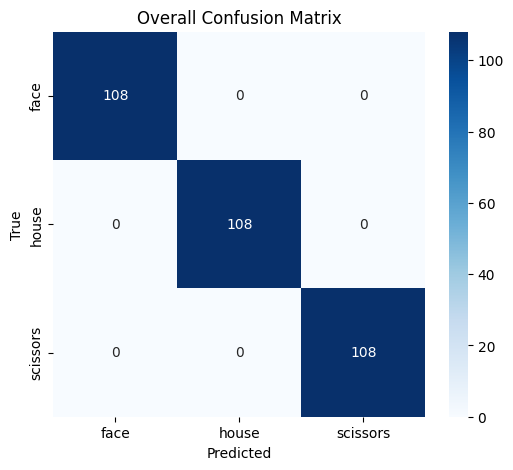

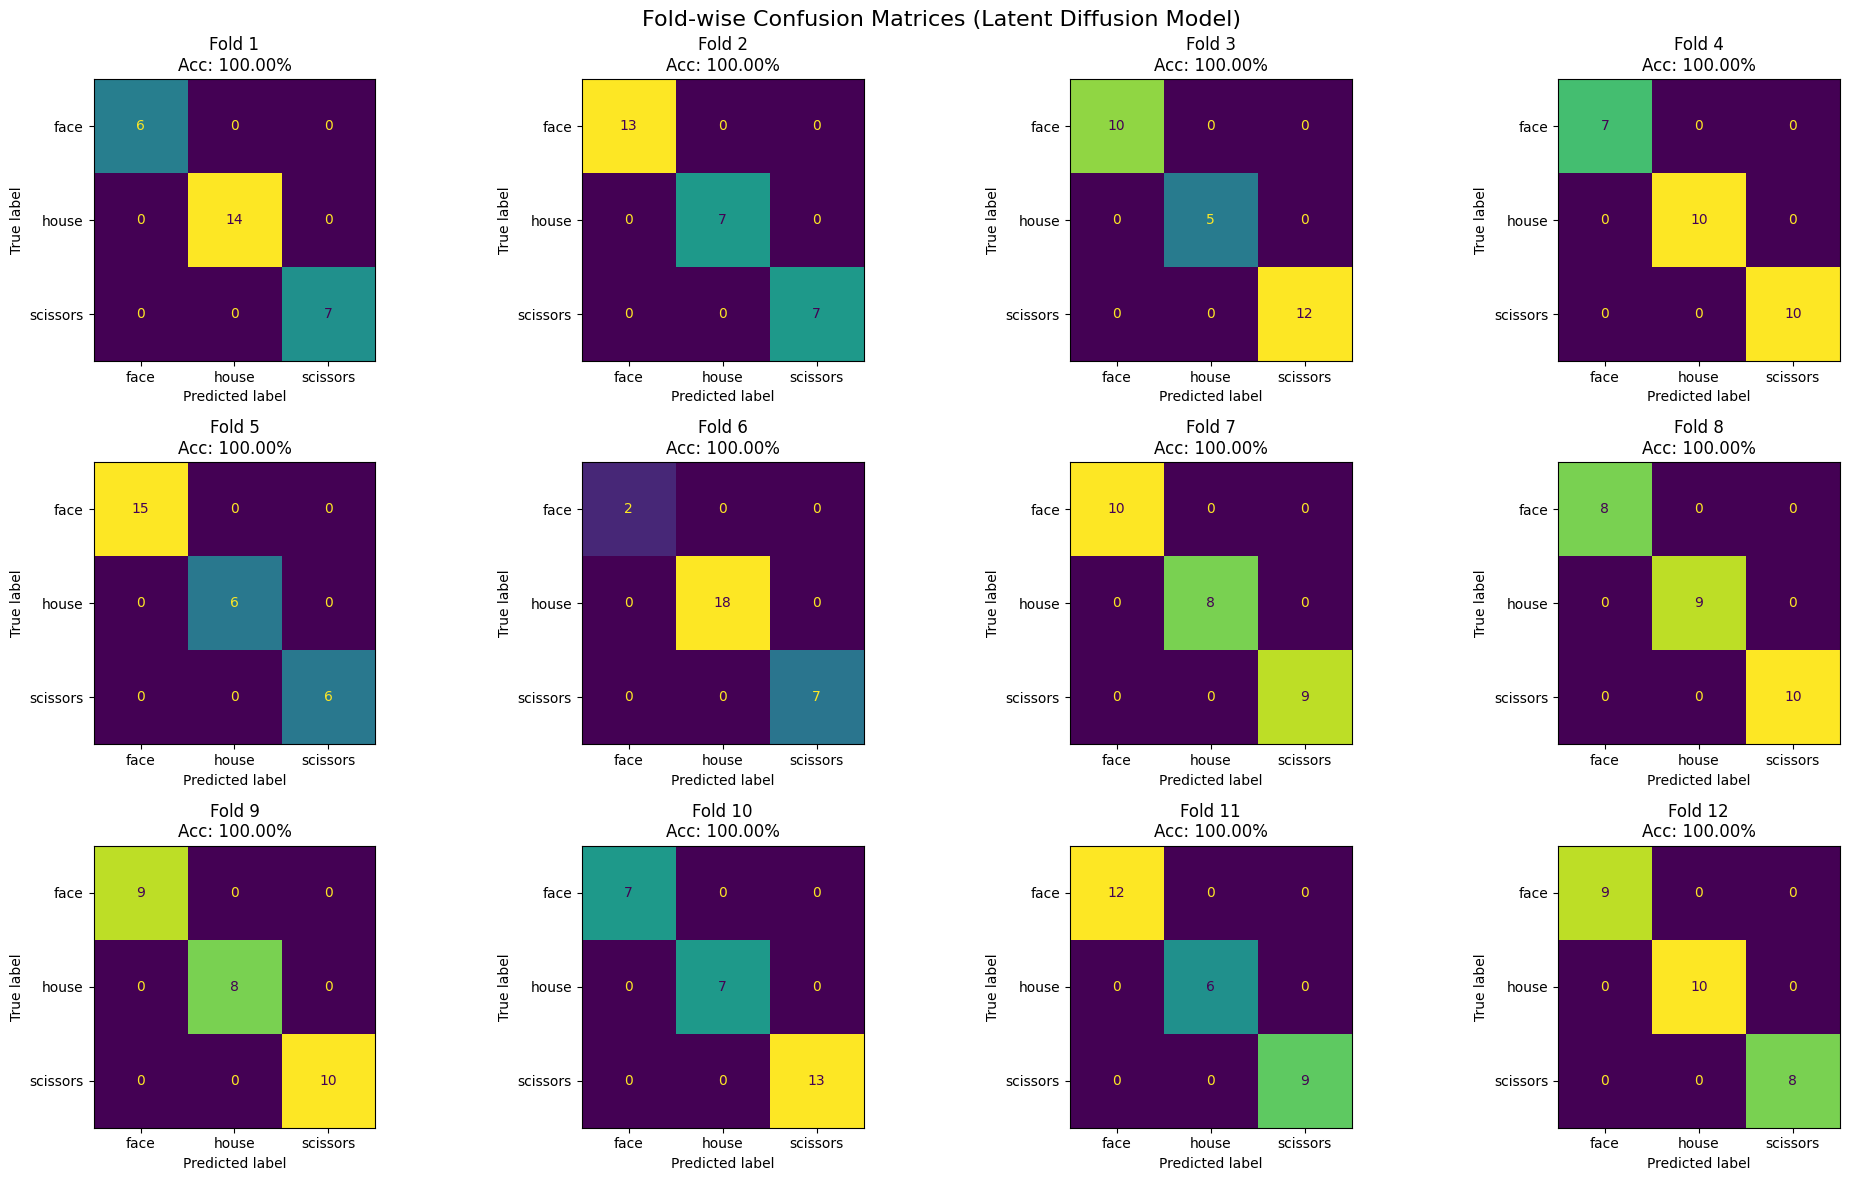

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import math

from nilearn import datasets, input_data
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# ===============================
# CONFIGURATION
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_FOLDS = 12
EPOCHS = 30
BATCH_SIZE = 32
LR = 1e-3

PCA_COMPONENTS = 150
LATENT_DIM = 64
DIFFUSION_STEPS = 100
SAMPLES_PER_CLASS = 108
CATEGORIES = ["face", "house", "scissors"]

# ===============================
# LOAD AND PREPARE DATA
# ===============================
haxby = datasets.fetch_haxby(subjects=[1])
labels_df = pd.read_csv(haxby.session_target[0], sep=" ")

masker = input_data.NiftiMasker(
    mask_img=haxby.mask_vt[0],
    standardize="zscore_sample"
)
X_all = masker.fit_transform(haxby.func[0])

# BALANCE DATASET
X_balanced = []
y_balanced = []
np.random.seed(42)

for idx, cat in enumerate(CATEGORIES):
    indices = np.where(labels_df["labels"] == cat)[0]
    selected = np.random.choice(indices, SAMPLES_PER_CLASS, replace=False)
    X_balanced.append(X_all[selected])
    y_balanced.append(np.full(SAMPLES_PER_CLASS, idx))

X = np.vstack(X_balanced)
y = np.concatenate(y_balanced)

print("Balanced samples per class:")
for i, cat in enumerate(CATEGORIES):
    print(f"{cat}: {np.sum(y == i)}")
print(f"Total samples: {X.shape[0]}")

# STANDARDIZE + PCA
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X)
print(f"PCA retained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

# ===============================
# MODEL DEFINITIONS
# ===============================
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.GELU(),
            nn.Linear(512, latent_dim)
        )
    def forward(self, x):
        return self.net(x)


def cosine_beta_schedule(T, s=0.008):
    x = torch.linspace(0, T, T+1)
    alphas = torch.cos(((x / T) + s) / (1+s) * torch.pi / 2)**2
    alphas = alphas / alphas[0]
    betas = 1 - (alphas[1:] / alphas[:-1])
    return torch.clip(betas, 1e-4, 0.999)

betas = cosine_beta_schedule(DIFFUSION_STEPS).to(DEVICE)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

def q_sample(z0, t):
    noise = torch.randn_like(z0)
    a = alpha_hat[t].unsqueeze(1)
    return torch.sqrt(a)*z0 + torch.sqrt(1-a)*noise, noise


class LatentDiffusionNet(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Linear(256, 256),
            nn.GELU()
        )
        self.noise_head = nn.Linear(256, latent_dim)
        self.class_head = nn.Linear(256, num_classes)
    def forward(self, z):
        h = self.shared(z)
        return self.noise_head(h), self.class_head(h)

# ===============================
# CROSS-VALIDATION TRAINING
# ===============================
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

fold_acc = []
fold_cms = []
y_preds_total, y_trues_total = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):
    print(f"\n🔁 Fold {fold+1}/{NUM_FOLDS}")

    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    encoder = Encoder(PCA_COMPONENTS, LATENT_DIM).to(DEVICE)
    ldm = LatentDiffusionNet(LATENT_DIM, len(CATEGORIES)).to(DEVICE)
    optimizer = optim.AdamW(list(encoder.parameters()) + list(ldm.parameters()), lr=LR)

    mse = nn.MSELoss()
    ce = nn.CrossEntropyLoss()

    train_ds = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train),
        torch.LongTensor(y_train)
    )
    loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    # -------- Training --------
    for epoch in range(EPOCHS):
        encoder.train()
        ldm.train()
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            z0 = encoder(xb)
            t = torch.randint(0, DIFFUSION_STEPS, (xb.size(0),), device=DEVICE)
            zt, noise = q_sample(z0, t)
            pred_noise, logits = ldm(zt)
            loss = 0.7*mse(pred_noise, noise) + 0.3*ce(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # -------- Evaluation --------
    encoder.eval()
    ldm.eval()
    with torch.no_grad():
        z = encoder(torch.FloatTensor(X_test).to(DEVICE))
        logits = ldm(z)[1]
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()

    acc = accuracy_score(y_test, y_pred)
    fold_acc.append(acc)
    fold_cms.append(confusion_matrix(y_test, y_pred))

    y_preds_total.extend(y_pred)
    y_trues_total.extend(y_test)

    print(f"✅ Fold Accuracy: {acc*100:.2f}%")

# ===============================
# FINAL RESULTS
# ===============================
print("\n📊 Mean Accuracy:", np.mean(fold_acc)*100)
print("📊 Std Accuracy:", np.std(fold_acc)*100)

print("\nClassification Report:")
print(classification_report(y_trues_total, y_preds_total, target_names=CATEGORIES))

# -------------------------------
# Overall Confusion Matrix
# -------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(
    confusion_matrix(y_trues_total, y_preds_total),
    annot=True, fmt='d', cmap='Blues',
    xticklabels=CATEGORIES, yticklabels=CATEGORIES
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Overall Confusion Matrix")
plt.show()

# -------------------------------
# Fold-wise Confusion Matrices
# -------------------------------
cols = 4
rows = math.ceil(NUM_FOLDS / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, cm in enumerate(fold_cms):
    disp = ConfusionMatrixDisplay(cm, display_labels=CATEGORIES)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"Fold {i+1}\nAcc: {fold_acc[i]*100:.2f}%")

# Remove unused axes
for j in range(NUM_FOLDS, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Fold-wise Confusion Matrices (Latent Diffusion Model)", fontsize=16)
plt.tight_layout()
plt.show()


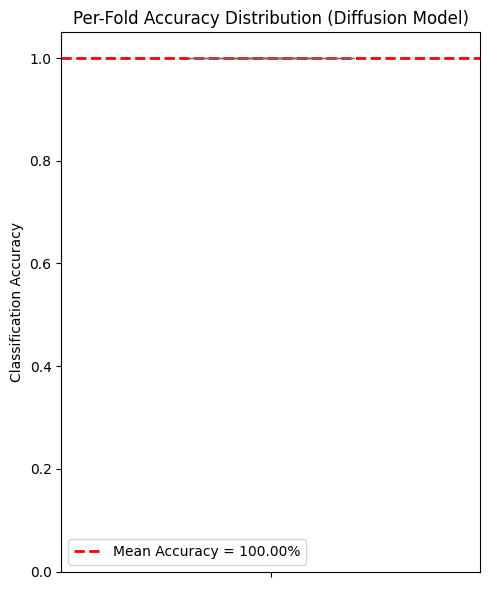

In [7]:
# -----------------------------
# Box plot of per-fold accuracy (Diffusion Model)
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# fold_accs is already collected during CV for DM
fold_accs_np = np.array(fold_acc)  # ensure it's a NumPy array

plt.figure(figsize=(5, 6))

sns.boxplot(
    y=fold_accs_np,
    width=0.4,
    showfliers=True,
    color='skyblue'
)

# Mean accuracy (dotted red line)
mean_acc = np.mean(fold_accs_np)
plt.axhline(
    mean_acc,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Mean Accuracy = {mean_acc*100:.2f}%"
)

plt.ylabel("Classification Accuracy")
plt.title("Per-Fold Accuracy Distribution (Diffusion Model)")
plt.ylim(0, 1.05)  # optional: keep y-axis in [0,1] range
plt.legend()
plt.tight_layout()
plt.show()

[fetch_haxby] Dataset found in /root/nilearn_data/haxby2001

/tmp/ipython-input-2399772131.py:43: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  X_all = masker.fit_transform(haxby.func[0])
/tmp/ipython-input-2399772131.py:43: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  X_all = masker.fit_transform(haxby.func[0])



================ Pairwise Classification: face vs house ================

PCA retained variance: 99.23%
Fold 1 Accuracy: 100.00%
Fold 2 Accuracy: 100.00%
Fold 3 Accuracy: 100.00%
Fold 4 Accuracy: 100.00%
Fold 5 Accuracy: 100.00%
Fold 6 Accuracy: 100.00%
Fold 7 Accuracy: 100.00%
Fold 8 Accuracy: 100.00%
Fold 9 Accuracy: 100.00%
Fold 10 Accuracy: 100.00%
Fold 11 Accuracy: 100.00%
Fold 12 Accuracy: 100.00%

Mean Accuracy: 100.00%
Std Accuracy: 0.00%
              precision    recall  f1-score   support

        face       1.00      1.00      1.00       108
       house       1.00      1.00      1.00       108

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



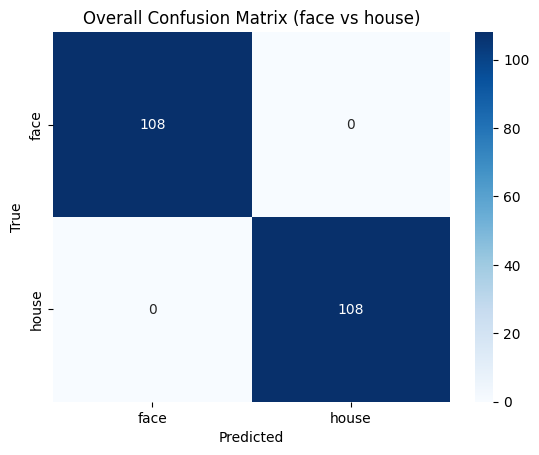

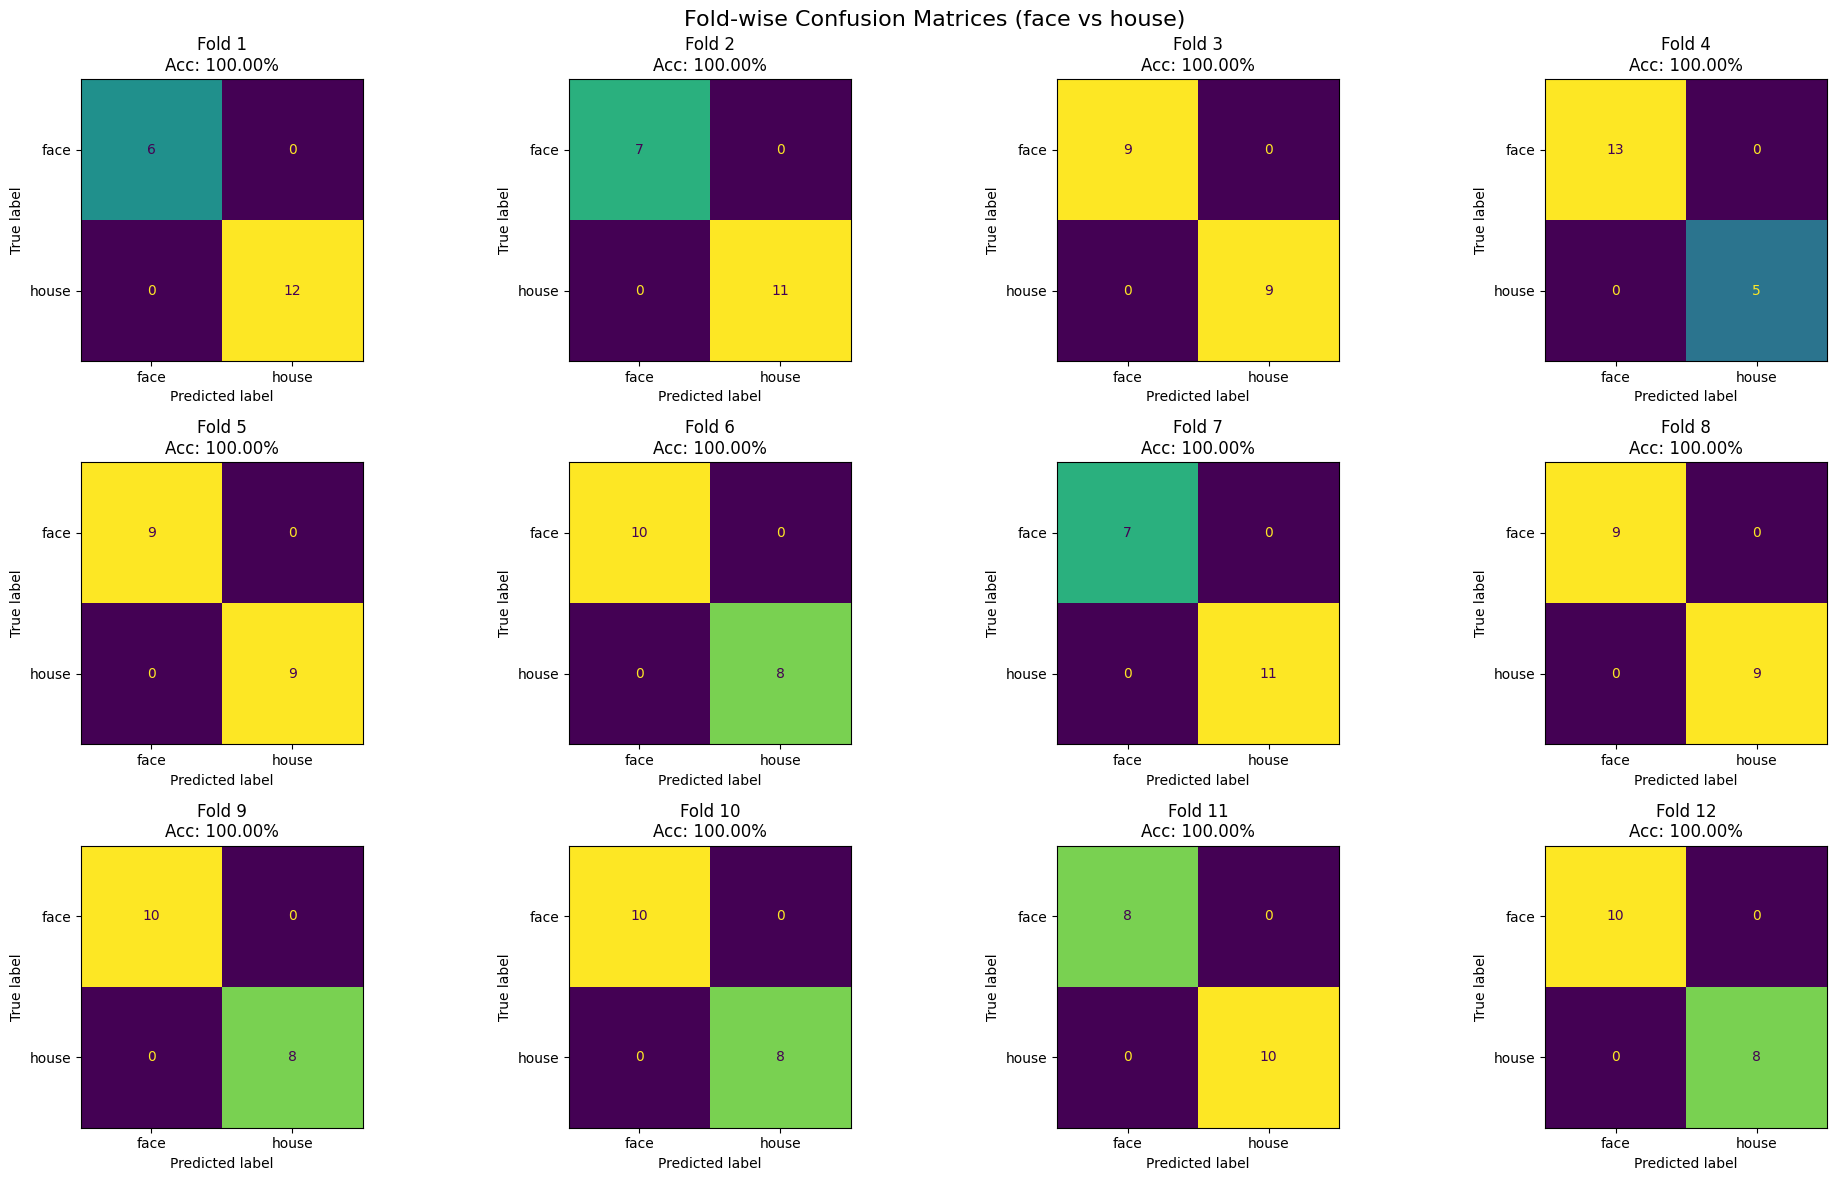


================ Pairwise Classification: face vs scissors ================

PCA retained variance: 99.17%
Fold 1 Accuracy: 100.00%
Fold 2 Accuracy: 100.00%
Fold 3 Accuracy: 100.00%
Fold 4 Accuracy: 100.00%
Fold 5 Accuracy: 100.00%
Fold 6 Accuracy: 100.00%
Fold 7 Accuracy: 100.00%
Fold 8 Accuracy: 100.00%
Fold 9 Accuracy: 100.00%
Fold 10 Accuracy: 100.00%
Fold 11 Accuracy: 100.00%
Fold 12 Accuracy: 100.00%

Mean Accuracy: 100.00%
Std Accuracy: 0.00%
              precision    recall  f1-score   support

        face       1.00      1.00      1.00       108
    scissors       1.00      1.00      1.00       108

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



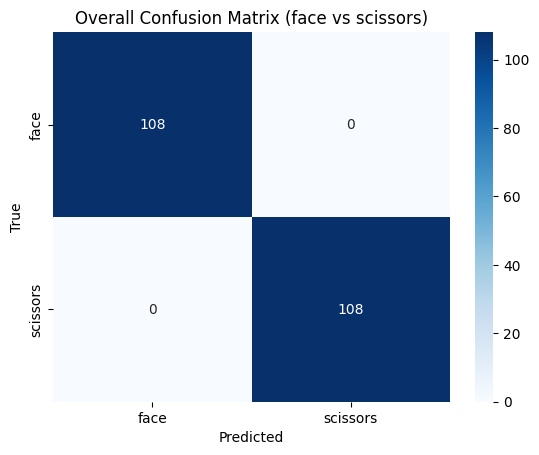

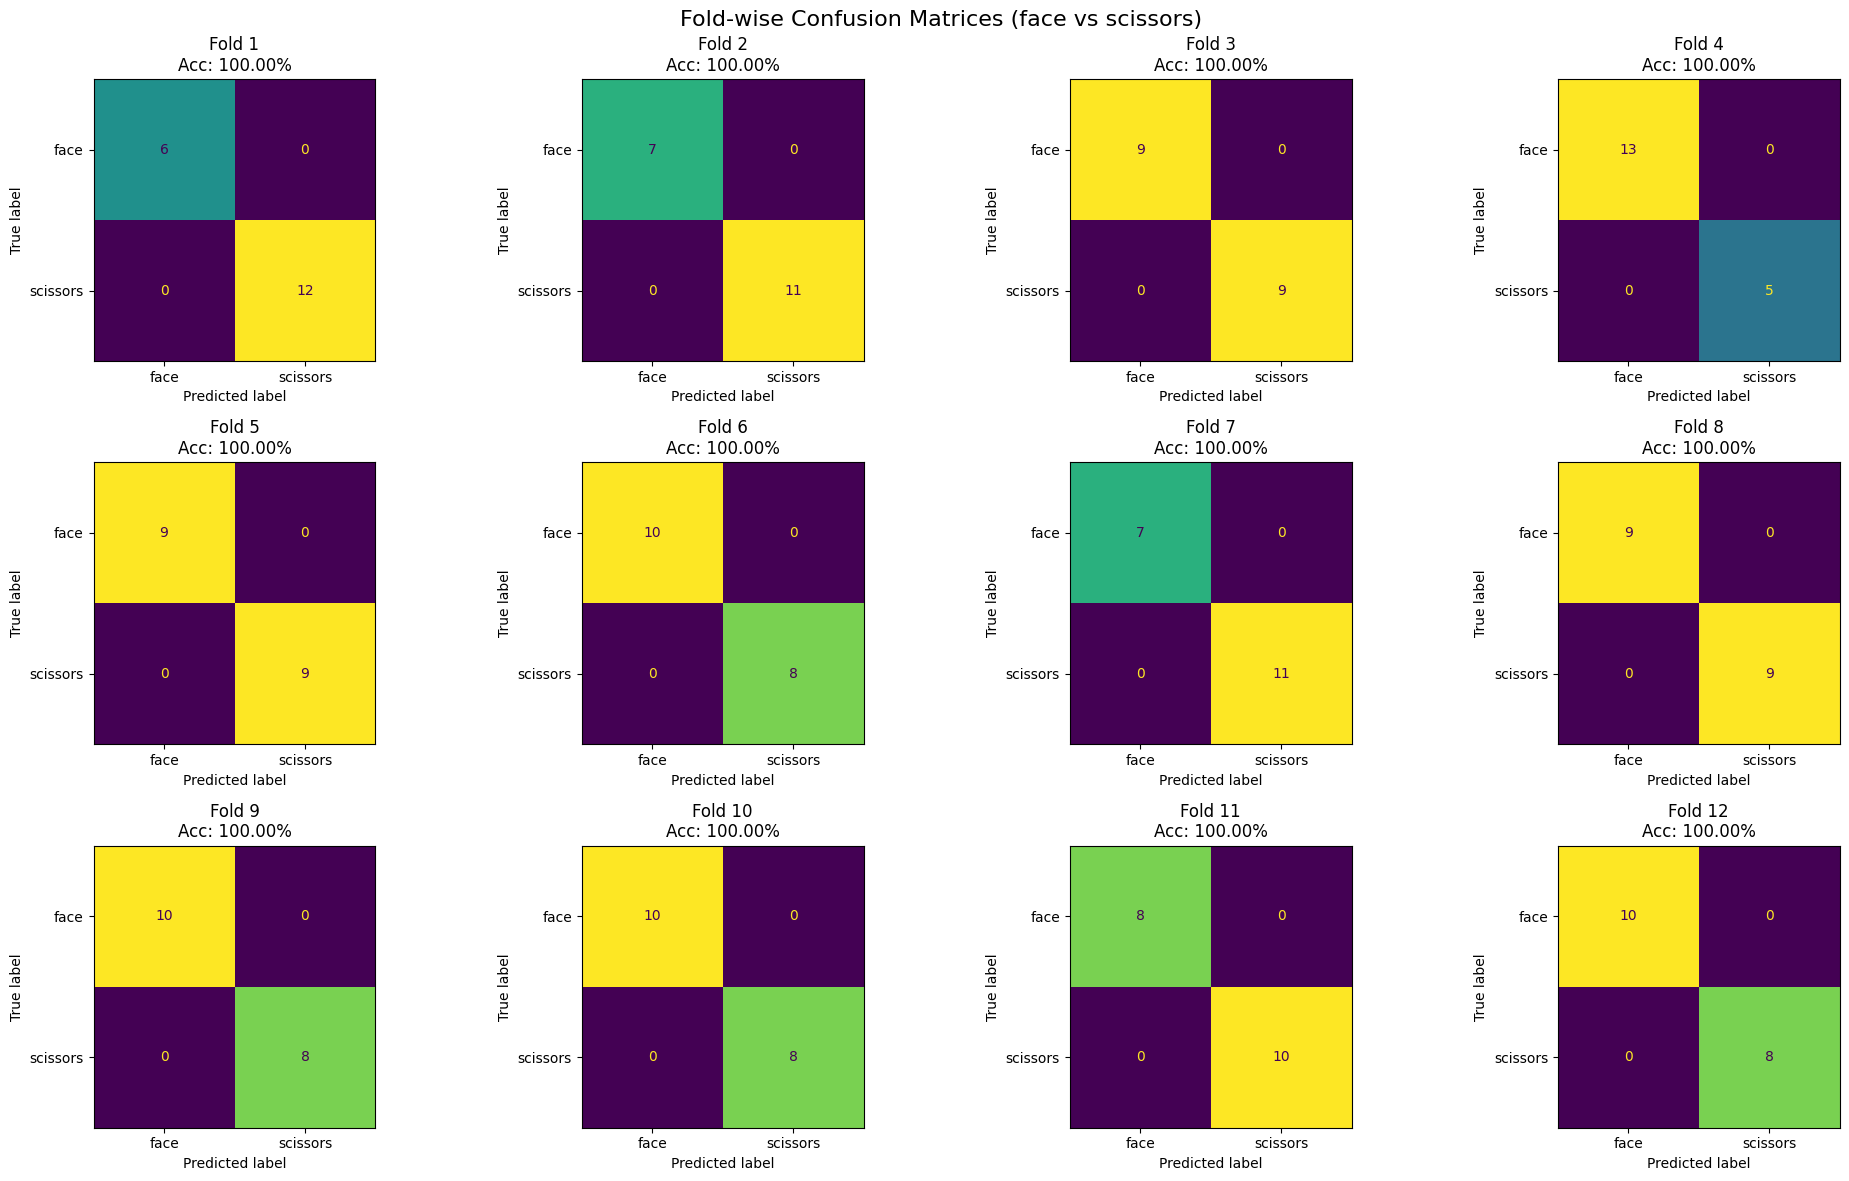


================ Pairwise Classification: house vs scissors ================

PCA retained variance: 99.19%
Fold 1 Accuracy: 100.00%
Fold 2 Accuracy: 100.00%
Fold 3 Accuracy: 100.00%
Fold 4 Accuracy: 100.00%
Fold 5 Accuracy: 100.00%
Fold 6 Accuracy: 100.00%
Fold 7 Accuracy: 100.00%
Fold 8 Accuracy: 100.00%
Fold 9 Accuracy: 100.00%
Fold 10 Accuracy: 100.00%
Fold 11 Accuracy: 100.00%
Fold 12 Accuracy: 100.00%

Mean Accuracy: 100.00%
Std Accuracy: 0.00%
              precision    recall  f1-score   support

       house       1.00      1.00      1.00       108
    scissors       1.00      1.00      1.00       108

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216



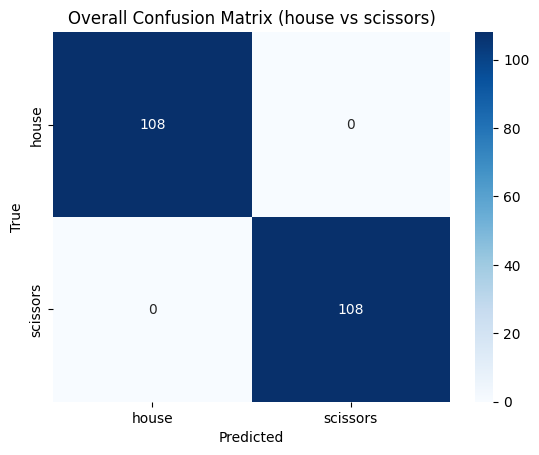

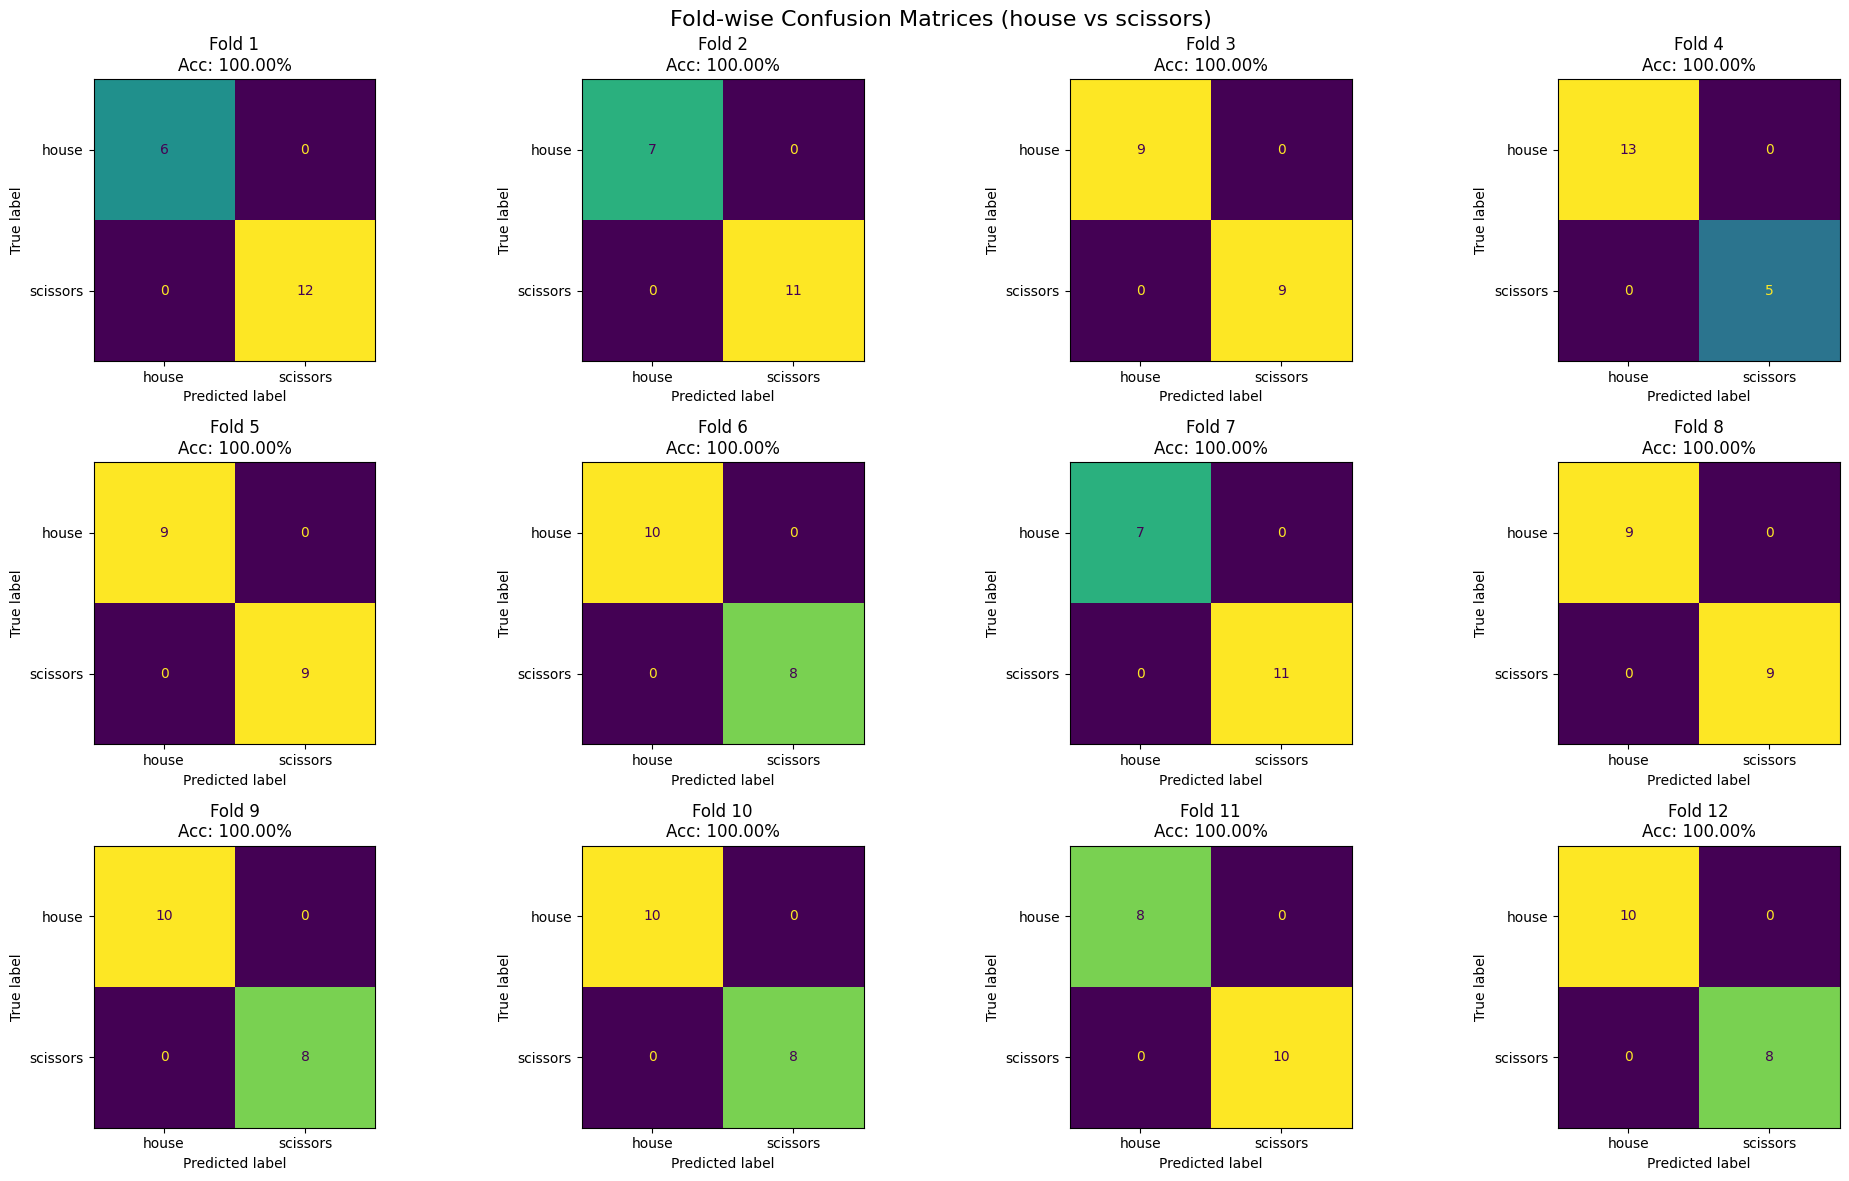

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import math

from nilearn import datasets, input_data
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from itertools import combinations

# ===============================
# CONFIGURATION
# ===============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_FOLDS = 12
EPOCHS = 30
BATCH_SIZE = 32
LR = 1e-3

PCA_COMPONENTS = 150
LATENT_DIM = 64
DIFFUSION_STEPS = 100
SAMPLES_PER_CLASS = 108
CATEGORIES = ["face", "house", "scissors"]

# ===============================
# LOAD HAXBY DATA
# ===============================
haxby = datasets.fetch_haxby(subjects=[1])
labels_df = pd.read_csv(haxby.session_target[0], sep=" ")

masker = input_data.NiftiMasker(
    mask_img=haxby.mask_vt[0],
    standardize="zscore_sample"
)
X_all = masker.fit_transform(haxby.func[0])

# ===============================
# MODEL DEFINITIONS
# ===============================
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.GELU(),
            nn.Linear(512, latent_dim)
        )
    def forward(self, x):
        return self.net(x)

def cosine_beta_schedule(T, s=0.008):
    x = torch.linspace(0, T, T+1)
    alphas = torch.cos(((x / T) + s) / (1+s) * torch.pi / 2)**2
    alphas = alphas / alphas[0]
    betas = 1 - (alphas[1:] / alphas[:-1])
    return torch.clip(betas, 1e-4, 0.999)

betas = cosine_beta_schedule(DIFFUSION_STEPS).to(DEVICE)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

def q_sample(z0, t):
    noise = torch.randn_like(z0)
    a = alpha_hat[t].unsqueeze(1)
    return torch.sqrt(a)*z0 + torch.sqrt(1-a)*noise, noise

class LatentDiffusionNet(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.GELU(),
            nn.Linear(256, 256),
            nn.GELU()
        )
        self.noise_head = nn.Linear(256, latent_dim)
        self.class_head = nn.Linear(256, num_classes)
    def forward(self, z):
        h = self.shared(z)
        return self.noise_head(h), self.class_head(h)

# ===============================
# PAIRWISE CLASSIFICATION
# ===============================
for cat1, cat2 in combinations(CATEGORIES, 2):
    print(f"\n================ Pairwise Classification: {cat1} vs {cat2} ================\n")

    # Filter for only the two classes
    idx = np.where((labels_df["labels"] == cat1) | (labels_df["labels"] == cat2))[0]
    X_pair = X_all[idx]
    y_pair = labels_df["labels"].iloc[idx].map({cat1:0, cat2:1}).values  # map to 0/1

    # Balance dataset
    np.random.seed(42)
    X_balanced = []
    y_balanced = []

    for i, label in enumerate([0,1]):
        indices = np.where(y_pair == label)[0]
        selected = np.random.choice(indices, SAMPLES_PER_CLASS, replace=False)
        X_balanced.append(X_pair[selected])
        y_balanced.append(np.full(SAMPLES_PER_CLASS, label))

    X_bal = np.vstack(X_balanced)
    y_bal = np.concatenate(y_balanced)

    # Standardize + PCA
    X_scaled = StandardScaler().fit_transform(X_bal)
    pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA retained variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

    # -----------------------------
    # Cross-validation
    # -----------------------------
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

    fold_acc = []
    fold_cms = []
    y_preds_total = []
    y_trues_total = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_pca)):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y_bal[train_idx], y_bal[test_idx]

        encoder = Encoder(PCA_COMPONENTS, LATENT_DIM).to(DEVICE)
        ldm = LatentDiffusionNet(LATENT_DIM, 2).to(DEVICE)  # 2 classes
        optimizer = optim.AdamW(list(encoder.parameters()) + list(ldm.parameters()), lr=LR)

        mse = nn.MSELoss()
        ce = nn.CrossEntropyLoss()

        train_ds = torch.utils.data.TensorDataset(
            torch.FloatTensor(X_train),
            torch.LongTensor(y_train)
        )
        loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

        # -------- Training --------
        for epoch in range(EPOCHS):
            encoder.train()
            ldm.train()
            for xb, yb in loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                z0 = encoder(xb)
                t = torch.randint(0, DIFFUSION_STEPS, (xb.size(0),), device=DEVICE)
                zt, noise = q_sample(z0, t)
                pred_noise, logits = ldm(zt)
                loss = 0.7*mse(pred_noise, noise) + 0.3*ce(logits, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # -------- Evaluation --------
        encoder.eval()
        ldm.eval()
        with torch.no_grad():
            z = encoder(torch.FloatTensor(X_test).to(DEVICE))
            logits = ldm(z)[1]
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()

        acc = accuracy_score(y_test, y_pred)
        fold_acc.append(acc)
        fold_cms.append(confusion_matrix(y_test, y_pred))
        y_preds_total.extend(y_pred)
        y_trues_total.extend(y_test)

        print(f"Fold {fold+1} Accuracy: {acc*100:.2f}%")

    # -----------------------------
    # Results
    # -----------------------------
    print(f"\nMean Accuracy: {np.mean(fold_acc)*100:.2f}%")
    print(f"Std Accuracy: {np.std(fold_acc)*100:.2f}%")
    print(classification_report(y_trues_total, y_preds_total, target_names=[cat1, cat2]))

    # Overall confusion matrix
    cm = confusion_matrix(y_trues_total, y_preds_total)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[cat1, cat2], yticklabels=[cat1, cat2])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Overall Confusion Matrix ({cat1} vs {cat2})")
    plt.show()

    # Fold-wise confusion matrices
    cols = 4
    rows = math.ceil(NUM_FOLDS/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()
    for i, cm in enumerate(fold_cms):
        disp = ConfusionMatrixDisplay(cm, display_labels=[cat1, cat2])
        disp.plot(ax=axes[i], colorbar=False)
        axes[i].set_title(f"Fold {i+1}\nAcc: {fold_acc[i]*100:.2f}%")
    for j in range(NUM_FOLDS, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"Fold-wise Confusion Matrices ({cat1} vs {cat2})", fontsize=16)
    plt.tight_layout()
    plt.show()
